In [1]:
import time
import numpy as np
import pandas as pd

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Preparation

In [2]:
# Mount gdrive
from google.colab import drive, files
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [3]:
# Specify input file location
training_file = 'gdrive/My Drive/shopee/train.csv'
test_file = 'gdrive/My Drive/shopee/test.csv'
user_file = 'gdrive/My Drive/shopee/users.csv'

In [4]:
# Load dataset
training_data = pd.read_csv(training_file)
test_data = pd.read_csv(test_file)
user_data = pd.read_csv(user_file)

In [5]:
# Merge with user data
training_data = pd.merge(training_data, user_data, on='user_id', how='inner')
test_data = pd.merge(test_data, user_data, on='user_id', how='inner')

In [6]:
# Change column type in training data
training_data['country_code'] = training_data['country_code'].astype('str')
training_data['attr_3'] = training_data['attr_3'].astype('str')
training_data['grass_date'] = pd.to_datetime(
    training_data.grass_date, 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

# Change column type in test data
test_data['country_code'] = test_data['country_code'].astype('str')
test_data['attr_3'] = test_data['attr_3'].astype('str')
test_data['grass_date'] = pd.to_datetime(
    test_data.grass_date, 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

In [7]:
# Specify input variables
variables = [
    'country_code',
    'subject_line_length', 
    'open_count_last_10_days',
    'open_count_last_30_days',
    'open_count_last_60_days'
]

In [8]:
# Data selection
x = training_data[variables]
y = training_data['open_flag']
x_test = test_data[variables]

In [9]:
# Encode categorical variables
x = pd.get_dummies(x)
x_test = pd.get_dummies(x_test)

In [10]:
# Split the data into training and validation set
x_train, x_validation, y_train, y_validation = train_test_split(
    x, 
    y, 
    test_size=0.2,
    random_state=42
)

In [11]:
# Generate a normalizer
scaler = preprocessing.StandardScaler().fit(x_train)

# Normalize the data
x_train = scaler.transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

# Modeling

In [12]:
# Define classifier
classifier = KNeighborsClassifier()

In [13]:
# Specify the list of hyperparameters
hyperparameters = {
    "n_neighbors": list(range(1, 21))
}

In [14]:
# Define the model selection method
mcc_scorer = make_scorer(matthews_corrcoef)
model_selection = GridSearchCV(
    classifier, 
    hyperparameters, 
    cv=5, 
    scoring=mcc_scorer
)

In [15]:
# Find the best hyperparameters
start = time.time()
model_selection.fit(x, y)
time.time() - start

113.61495804786682

In [16]:
# Show the best hyperparameters
model_selection.best_params_

{'n_neighbors': 15}

In [17]:
# Show the best score
model_selection.best_score_

0.4091859934802445

In [18]:
# Use artificial data
oversampling = SMOTE(sampling_strategy=0.3)
x_train, y_train = oversampling.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [19]:
# Train the classifier using the best hyperparameters
classifier = KNeighborsClassifier(
    **model_selection.best_params_
)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [20]:
# Evaluate the model using the evaluation set
y_prediction = classifier.predict(x_validation)
print("MCC\t\t: %.4f" % matthews_corrcoef(y_validation, y_prediction))

MCC		: 0.4904


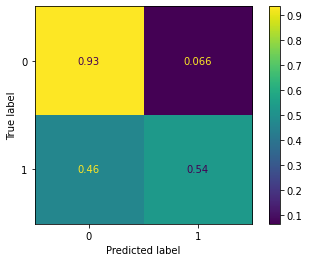

In [21]:
# Evaluate the model using confusion matrix
plot_confusion_matrix(classifier, x_validation, y_validation, normalize='true');

# Submission

In [22]:
# Retrain the classifier with all training data
classifier = KNeighborsClassifier(
    **model_selection.best_params_
)
classifier.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [23]:
# Generate prediction
prediction = classifier.predict(x_test)
test_data['open_flag'] = prediction

In [24]:
# Generate submission file
test_data.loc[:, ['row_id', 'open_flag']].to_csv('submission.csv', index=False)